# Step by Step Process for Planning an A/B Test

[Link](read://https_towardsdatascience.com/?url=https%3A%2F%2Ftowardsdatascience.com%2Fstep-by-step-for-planning-an-a-b-test-ef3c93143c0b)

## Libraries import

In [1]:
import numpy as np

from statsmodels.stats.power import tt_ind_solve_power
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

In [2]:
colors = ['#1F77B4', '#FF7F0E', '#CC3363', '#009B72', '#FFE900']

## Introduction

To prevent the post from being too lengthy, I am only going to involve the planning process and I will cover the other aspects of experiments in future blog posts. The planning process includes:

1. Setting hypotheses;
2. Getting baseline numbers for metrics;
3. Minimum Detectable Effect (MDE);
4. Power Analysis (To determine the sample size required to conclude an experiment);
5. Estimate duration of the experiment;
6. Discuss with stakeholders.

I am going to only talk about the simplest and most common form of experiment (i.e. A/B test a.k.a two variant test) using the frequentist approach, which should suffice for most people or organizations starting out.

## 1. Setting hypotheses

Just like how we’re thought in school, an experiment starts with a hypothesis. You may have multiple hypotheses you want to test but always have a main one. I will give two examples here:

1. You work at an e-commerce company, you think that displaying discounted amount at checkout increases checkout rate.
2. You eliminated the need to provide phone number and address to sign up for membership. You think that this is going to increase conversion rate.

It is useful to convert these statements into more statistical forms because the statements are clearer and it reduces the chance of making mistakes on what exact metric to measure. For example, in the first case, I would write:

**Checkout Rate (One-tailed)**
- $H_0$: *There is no difference in checkout rate between the control and treatment group.*
- $H_1$: *Checkout rate of the treatment group is higher than checkout rate of the control group.*

*We hope to reject the null hypothesis and conclude that the checkout rate of the treatment group is statistically significantly higher than that of the control group. (in italic format).*

In most cases, there will be a few secondary metrics you want to measure, you can write them in the same format too. Although it is common to always want to measure improvement, you should also always **think about the adverse effects that your treatment might bring**.

For instance, in the second case, I will also consider conversion to paying member as a secondary metric, I might hypothesize that the new sign up process can appear as insecure to some people and discourage them from becoming a paying member. I would then write my secondary metric as:

**Paid Membership Conversion Rate (Two-tailed)**
- $H_0$: *There is no difference in paid membership conversion rate between the control and treatment group.*
- $H_1$: *There is a difference in paid membership conversion rate between the control and the treatment group.*

*We hope to fail to reject the null hypothesis and conclude that there is no statistically significant difference between paid membership conversion rate of the treatment group and the control group.*

Hence experiment should not be thought of as a way to measure if a treatment brings improvement, but can also be used to measure if a treatment causes harm.

## 2. Get a baseline of your current metrics

This is essential because it will be part of our sample size required calculation. Secondly, it helps us get a sense of what the current numbers are.

## 3. What is a meaningful effect size to you?

Given enough sample size, we will usually be able to find a statistically significant difference between two groups even if there is only a very slight difference. This is because the confidence interval of our estimate decreases as sample size increases.

The chart below shows one distribution with mean 0.1 and another one with mean 0.15 under different sample sizes.

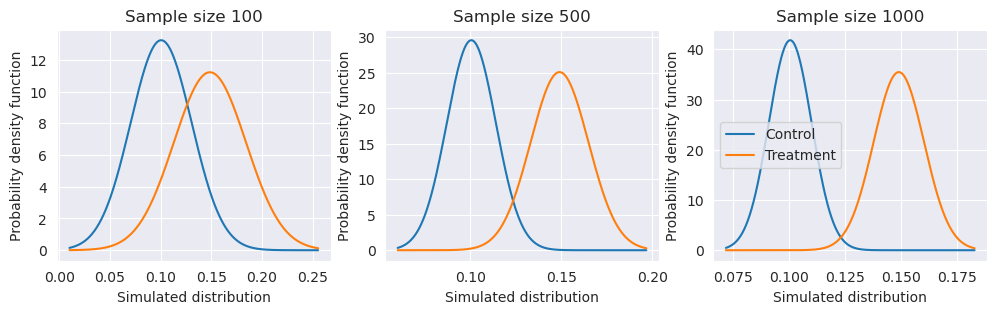

In [3]:
n = 10000

# Control
p_0 = 0.1
var_0 = p_0 * (1 - p_0)
std_0 = np.sqrt(var_0)
norm_0 = stats.norm(p_0, std_0)
group_0 = norm_0.rvs(n)

# Treatment
p_1 = 0.15
var_1 = p_1 * (1 - p_1)
std_1 = np.sqrt(var_1)
norm_1 = stats.norm(p_1, std_1)
group_1 = norm_1.rvs(n)

fig, ax = plt.subplots(
    ncols=3,
    nrows=1,
    sharex=False,
    sharey=False,
    squeeze=True,
    figsize=(4 * 3, 3 * 1)
)

boots_list = [100, 500, 1000]

for i, boots in enumerate(boots_list):

    group_0_boots_mean = []
    group_0_boots_std = []

    group_1_boots_mean = []
    group_1_boots_std = []

    for j in range(boots):
        
        np.random.seed(j)
        sample_0 = np.random.choice(group_0, size=n, replace=True)
        group_0_boots_mean.append(np.mean(sample_0))
        group_0_boots_std.append(np.std(sample_0))
        
        sample_1 = np.random.choice(group_1, size=n, replace=True)
        group_1_boots_mean.append(np.mean(sample_1))
        group_1_boots_std.append(np.std(sample_1))
        
    mean_0 = np.mean(group_0_boots_mean)
    std_error_0 = np.mean(group_0_boots_std) / np.sqrt(boots)

    mean_1 = np.mean(group_1_boots_mean)
    std_error_1 = np.mean(group_1_boots_std) / np.sqrt(boots)

    x_min = np.min([mean_0 - 3 * std_error_0, mean_1 - 3 * std_error_1])
    x_max = np.max([mean_0 + 3 * std_error_0, mean_1 + 3 * std_error_1])

    x = np.linspace(x_min, x_max, 1000)
    y_h0 = stats.norm(mean_0, std_error_0).pdf(x)
    y_h1 = stats.norm(mean_1, std_error_1).pdf(x)


    ax[i].set_title(f'Sample size {boots}')
    
    ax[i].plot(x, y_h0, color=colors[0], label=r'Control')
    ax[i].plot(x, y_h1, color=colors[1], label=r'Treatment')

    ax[i].set_ylabel('Probability density function')
    ax[i].set_xlabel('Simulated distribution')

plt.legend()
plt.show()

This is intuitive because we are more confident with our estimate of the mean as our sample size grows, hence why the distribution becomes narrower. This also implies that the sample size requirement grows if you want to confidently detect a small difference between two populations.

Thus, it is very important to decide what change is considered **meaningful enough for you to take an action**.

> **For example:**\
> If you found a statistically significant improvement of 0.05% (from 15.3% to 15.35%) in checkout rate from displaying the discounted amount at the checkout page. Should you really implement the change? This is also commonly known as Minimum Detectable Effect (MDE), which I will cover in detail in future posts.

Deciding on a meaningful effect size and committing to it prevent you from deviating from the original plan after the experiment. If a 1% change is a good enough signal to rollout the treatment to everyone, then be certain that you will do it only if the effect is more than 1%.

Although it should not be something people do theoretically, due to how sample size requirement change with MDE, I find it useful to take the estimated sample size I can get for my experiment into consideration when thinking about MDE. I cannot set my MDE to be too small if I do not expect too many samples in my experiment.

## 4. Perform power analysis

This is probably the part least discussed in other articles. Set the target significance value, target statistical power and an allocation ratio (usually 1) and calculate the sample size required to detect the MDE you desire at the target significance value and statistical power under a certain allocation ratio.

**Target significance value, $\alpha$:**
- There is a $\alpha\%$ chance that we reject the null hypothesis when the null is correct;
- Common values are 0.01, 0.05 and 0.1, depending on the cost of making such mistake, the higher the cost, the lower your $\alpha$ should be.

**Target Statistical Power, $1-\beta$:**
- There is a $1-\beta \%$ chance of us failing to reject the null when there is an actual significant change of MDE;
- Common values are 0.8, 0.85, 0.9 and 0.95, 0.99;
- This depends on how costly it is to miss this change when there is an actual change, the higher the cost, the lower your $\beta$ should be and hence higher target statistical power.

**Allocation Ratio:**
- The ratio of treatment to control group, usually set at 1 for highest statistical power given a fixed sample size.

After setting these experiment parameters, I will come up with this table, containing the essence of an experiment plan.


| Metric                     | Checkout Rate |
| :------------------------- | :-----------: |
| Estimated Baseline Value   | 0.15          |
| Target Value (Effect Size) | 0.18 (0.081)  |
| Target Significance Value  | 0.05          |
| Target Statistical Power   | 0.95          |
| Allocation Ratio (N2 / N1) | 1             |
| Number of groups           | 2             |
| Total Sample Size Required | 6618          |

To calculate the sample size we do as following:

In [4]:
p_0 = 0.15
var_0 = p_0 * (1 - p_0)

p_1 = 0.18
var_1 = p_1 * (1 - p_1)

# Cohen’s D (standardized mean difference)
cohen_d = (abs(p_0 - p_1) / np.sqrt((var_0 + var_1) / 2))

n_obs = tt_ind_solve_power(
    effect_size=cohen_d,
    power=0.95,
    nobs1=None,
    ratio=1.0,
    alpha=0.05,
    alternative='larger'
)

n_obs = int(n_obs) + 1

print(f'Effect size: {cohen_d:.3f}')
print(f'Sample size: {n_obs}')

Effect size: 0.081
Sample size: 3309


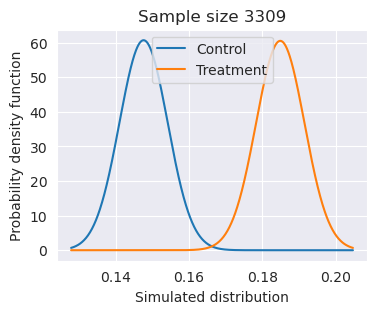

In [5]:
n = n_obs

# Control
std_0 = np.sqrt(var_1)
norm_0 = stats.norm(p_0, std_0)
group_0 = norm_0.rvs(n)

# Treatment
std_1 = np.sqrt(var_1)
norm_1 = stats.norm(p_1, std_1)
group_1 = norm_1.rvs(n)

fig, ax = plt.subplots(
    ncols=1,
    nrows=1,
    sharex=False,
    sharey=False,
    squeeze=True,
    figsize=(4, 3)
)

boots = n

group_0_boots_mean = []
group_0_boots_std = []

group_1_boots_mean = []
group_1_boots_std = []

for j in range(boots):
    
    np.random.seed(j)
    sample_0 = np.random.choice(group_0, size=n, replace=True)
    group_0_boots_mean.append(np.mean(sample_0))
    group_0_boots_std.append(np.std(sample_0))
    
    sample_1 = np.random.choice(group_1, size=n, replace=True)
    group_1_boots_mean.append(np.mean(sample_1))
    group_1_boots_std.append(np.std(sample_1))
    
mean_0 = np.mean(group_0_boots_mean)
std_error_0 = np.mean(group_0_boots_std) / np.sqrt(boots)

mean_1 = np.mean(group_1_boots_mean)
std_error_1 = np.mean(group_1_boots_std) / np.sqrt(boots)

x_min = np.min([mean_0 - 3 * std_error_0, mean_1 - 3 * std_error_1])
x_max = np.max([mean_0 + 3 * std_error_0, mean_1 + 3 * std_error_1])

x = np.linspace(x_min, x_max, 1000)
y_h0 = stats.norm(mean_0, std_error_0).pdf(x)
y_h1 = stats.norm(mean_1, std_error_1).pdf(x)


ax.set_title(f'Sample size {boots}')

ax.plot(x, y_h0, color=colors[0], label=r'Control')
ax.plot(x, y_h1, color=colors[1], label=r'Treatment')

ax.set_ylabel('Probability density function')
ax.set_xlabel('Simulated distribution')

plt.legend()
plt.show()

Often give some room for error when deciding on the sample size required because there are a lot of things that can go wrong during the experiment. When these errors happen, it is likely that you have to remove some of your experiment samples to prevent them from affecting your results. For example, there might be another marketing campaign that introduces bias in favor of the control group.

It is good if you are aware of these events during the experiment, which you can then exclude these from your experiment samples so that your experiment still run until it achieves the target sample size. But I often find that it is impossible to be aware of all these moving parts until after the experiment. You will then realize that you do not have enough sample size to conclude the experiment after excluding these unusable samples. How much more room to give will depend on how confident you are about executing your experiment correctly.

## 5. Estimate duration of the experiment

Given the sample size required, estimate how long you need to achieve the target sample size given your traffic or volume. As a rule of thumb, there will usually be some seasonality effect like the day of the week or hour of the day.

>**For example**:\
>how your experiment subjects react to the treatment might be different depending on these seasonality factors.

Hence, if you think that you can reach your sample size in a few days, I would suggest expanding it to one week or even two weeks in most cases to get a more robust result.

If it takes months to reach your target sample size, then maybe you might want to increase the MDE to reduce the sample size required. The pros of doing this is that you can save time, but the disadvantage is that your treatment must have a large enough impact for you to confidently reject your null hypothesis.

## 6. Discuss with your stakeholders

Discuss with your engineers about how to implement the experiment. Common questions include:

1. What extra events to log?
2. How to assign treatment to users?
3. How to pipe these events into your data warehouse for experiment monitoring?
4. What can go wrong during the experiment and what are your backup plans?

## Conclusion

I have described the step by step process on how to plan a simple two-variant experiment in this post. I hope that this blog post helps you get started with planning some experiment in your team. However, I did not cover many more aspects, which I hope to cover in the future, such as:

1. Common things to monitor during an experiment;
2. Common pitfalls in experiments;
3. More than 2 variants of experiments;
4. Full factorial experiment design;
5. Common statistical test for experiments.

Last but not least, it is extremely important to plan your experiment properly to reduce the chance of making mistakes during the experiment, or even worse, concluding the experiment with the wrong results. It might be time consuming to plan all these out at the beginning, but you will eventually be faster the more your practice.